# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Загрузка необходимых библиотек:

In [3]:
!pip install -q phik==0.11.1
!pip install -q scikit-learn==1.1.3
!pip install -q catboost
!pip install -q shap
!pip install -q optuna 
!pip install -q vega

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats as st
import phik

In [220]:
# подготовка данных
from sklearn.model_selection import train_test_split, cross_val_score
# модели
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from optuna.integration import OptunaSearchCV
from optuna import distributions, visualization
from sklearn.dummy import DummyRegressor, DummyClassifier
import optuna
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
# метрики регрессии
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, mean_absolute_error
# загружаем функцию для оценки значимости признаков при классификации 
import shap

## Загрузка и подготовка данных

Чтение исходных данных в таблицы:

In [5]:
try:
    derrick1area = pd.read_csv('geo_data_0.csv')
    derrick2area = pd.read_csv('geo_data_1.csv')
    derrick3area = pd.read_csv('geo_data_2.csv')
except:
    derrick1area = pd.read_csv('/datasets/geo_data_0.csv')
    derrick2area = pd.read_csv('/datasets/geo_data_1.csv')
    derrick3area = pd.read_csv('/datasets/geo_data_2.csv')

Выполним небольшую предобработку данных, хотя данные не разнообразны и скорее всего проблем нет.

In [6]:
table_set = [derrick1area, derrick2area, derrick3area]
table_names =  ['группа скажин-1', 'группа скажин-2', 'группа скажин-3']

In [7]:
[display(item.sample(3)) for item in table_set];   

,id,f0,f1,f2,product
74013,QgF3q,1.902064,0.164996,2.343126,139.017676
64936,CS7J6,1.288268,-0.388358,7.720459,148.659328
83926,qm4hn,0.240526,-0.153789,-1.771338,62.371270


,id,f0,f1,f2,product
10317,zqV7O,-4.798981,-6.217620,3.996943,110.992147
42605,gPfVP,9.634902,-5.152943,3.994324,107.813044
4217,dK6LJ,-5.872097,0.064513,4.998300,137.945408


,id,f0,f1,f2,product
46209,3yMWq,1.414958,1.579373,1.798071,163.597299
82375,6X9WN,1.299101,-2.277118,-2.761174,33.341222
90588,MZGKm,-0.146767,-0.302262,-6.416051,48.472349


 - Все таблицы содержат одинаковые столбцы, в том числе id номер скважины;
 - Все основные данные числовые непрерывные.

In [8]:
[item.info() for item in table_set];

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

 - Пропусков в данных нет

Проверим данные на наличие явных дубликатов:

In [9]:
[print('Количество дубликатов по таблицам:', '"', table_names[i], '"' ,item.duplicated().sum()) for i, item in enumerate(table_set)]; 

Количество дубликатов по таблицам: " группа скажин-1 " 0
Количество дубликатов по таблицам: " группа скажин-2 " 0
Количество дубликатов по таблицам: " группа скажин-3 " 0


 - Явных дубликатов нет

Возможно оставить индексацию по номеру, а можно перейти к индексации по 'id' - что имеет больше смысла (в том числе сразу исключаем id из списка признаков при обучении модели - это не проблема но что тянуть)

In [41]:
[item.set_index('id', inplace=True) for item in table_set];

KeyError: "None of ['id'] are in the columns"

In [42]:
table_set = [derrick1area, derrick2area, derrick3area];

Проверим на дубликаты в данных еще раз без учета 'id' потому, что он не является значимым признаком, а чтобы не переобучить модель на тренеровочной выборке их не должно быть. Хотя на выборки делим позже, но проверить сейчас нам ничего не мешает.

In [11]:
[print('Количество дубликатов по таблицам:', '"', table_names[i], '"' ,item.duplicated().sum()) for i, item in enumerate(table_set)]; 

Количество дубликатов по таблицам: " группа скажин-1 " 0
Количество дубликатов по таблицам: " группа скажин-2 " 0
Количество дубликатов по таблицам: " группа скажин-3 " 0


 - Явных дубликатов нет

Исследуем распределение признаков скважин по месторождениям.

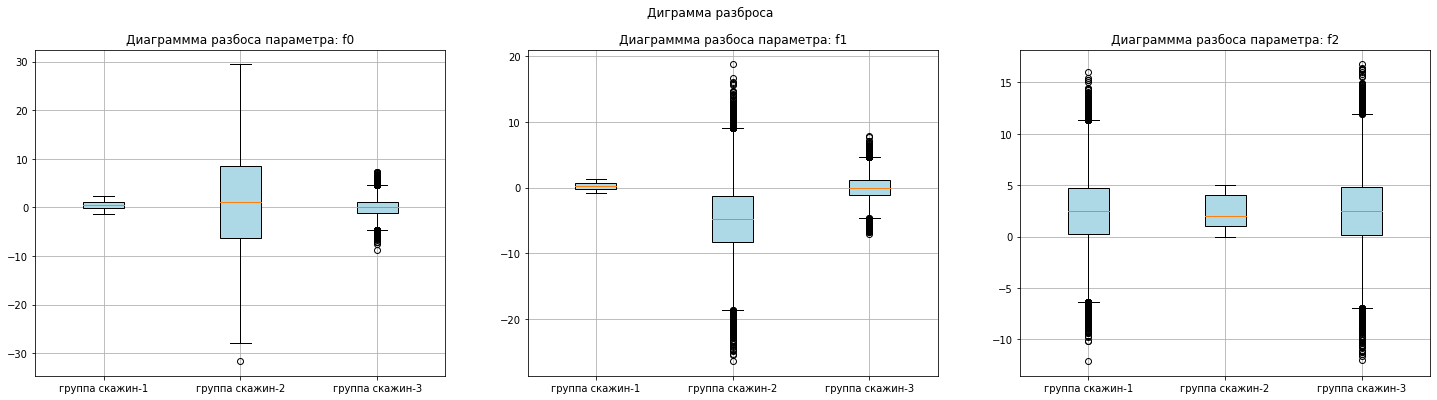

In [30]:
cols = ['f0', 'f1', 'f2']
n = len(cols)
fig, ax = plt.subplots(1, n, figsize=(25, 6))
fig.suptitle('Диграмма разброса')
boxprops = dict(facecolor = "lightblue")
for i, col in enumerate(cols):
    dic = {}
    for j in range(3):
        dic[table_names[j]]=table_set[j][col]
    ax[i].boxplot(dic.values(), patch_artist = True, boxprops= boxprops)
    ax[i].set_xticklabels(dic.keys())
    ax[i].set_title('Диаграммма разбоса параметра: '+ cols[i])
    ax[i].grid()
plt.show()

Интересно, что все группы скважин различаются, при этом группа 1 и группа 3 более "похожи" друг на друга.

Посмотрим что с целевым признаком:

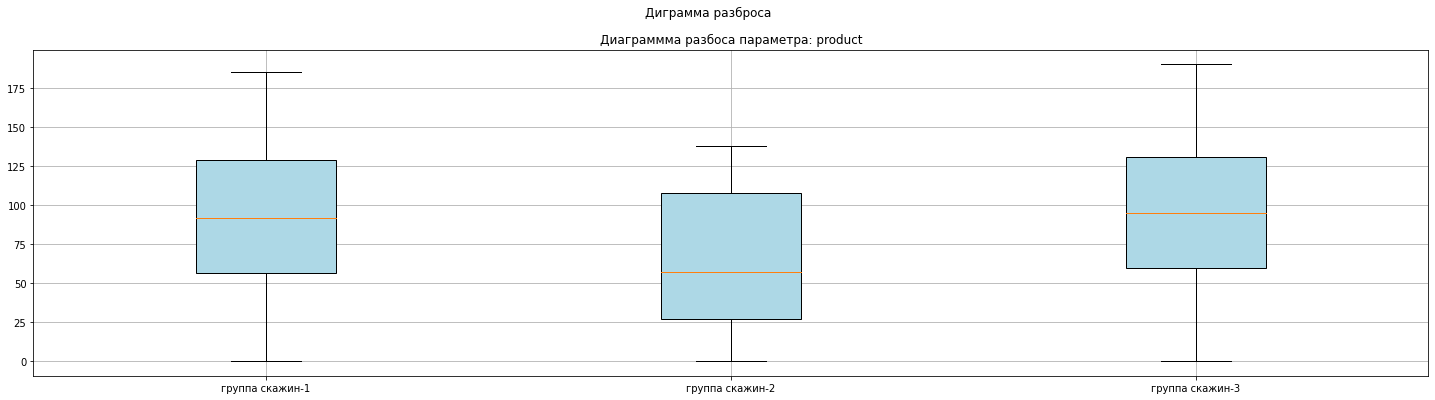

In [53]:
cols = 'product'
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
fig.suptitle('Диграмма разброса')
boxprops = dict(facecolor = "lightblue")
dic = {}
for j in range(3):
    dic[table_names[j]]=table_set[j][cols]
ax.boxplot(dic.values(), patch_artist = True, boxprops= boxprops)
ax.set_xticklabels(dic.keys())
ax.set_title('Диаграммма разбоса параметра: '+ cols)
ax.grid()
plt.show()

- В принципе можно сразу сказать, что в среднем произодство для второй группы скважин будет ниже чем для первой и третьей;
- Первая и третья группа как по распределению признаков так и целевого значения похожи - нужно посмотреть что сможет спрогнозировать модель.

In [54]:
[display(item.describe()) for item in table_set];  

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Здесь интересны скважины с нулевой производительностью:

In [82]:
[display(item.loc[item['product']==0].head(5)) for item in table_set];

,f0,f1,f2,product
id,,,,
zCM5W,-0.702064,0.375992,0.236572,0.0


,f0,f1,f2,product
id,,,,
OXyvW,16.320755,-0.562946,-0.001783,0.0
igmai,6.695604,-0.749449,-0.007630,0.0
Qjy5w,21.418478,-5.134490,-0.002836,0.0
G6WCj,6.822701,3.104979,-0.000723,0.0
MzQhL,6.750150,-11.893512,-0.001601,0.0


,f0,f1,f2,product
id,,,,
qeefd,-0.865596,-1.615247,-4.126441,0.0


Интересно, что у всех значений "product" = 0, значения "f2" во второй группе скважин тоже около нуля - построим распределение "f2".

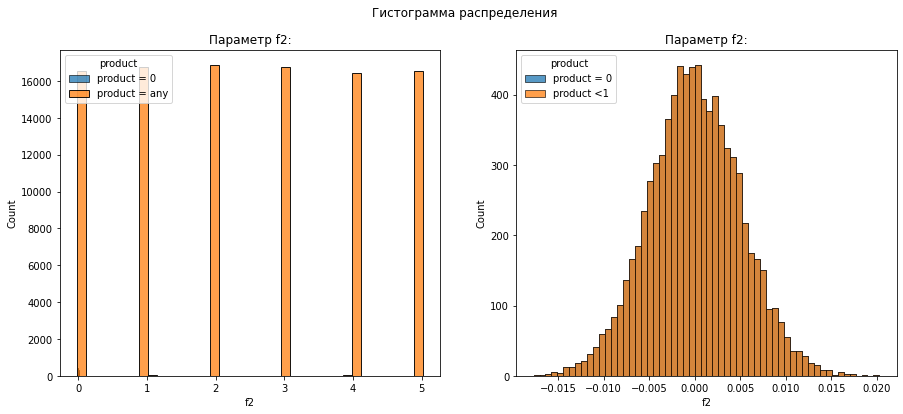

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Гистограмма распределения')
[sns.histplot(data=derrick2area.loc[derrick2area['product']==0], x='f2', ax=ax[i], color='tab:blue') for i in range(2)]
sns.histplot(data=derrick2area, x='f2', color='tab:orange', ax=ax[0])
sns.histplot(data=derrick2area.loc[derrick2area['product']<1], x='f2', color='tab:orange', ax=ax[1])
[ax[i].set_title('Параметр f2:') for i in range(2)]
ax[0].legend(title='product', loc='upper left', labels=['product = 0', 'product = any'])
ax[1].legend(title='product', loc='upper left', labels=['product = 0', 'product <1'])
plt.show()

<Axes: xlabel='f0', ylabel='product'>

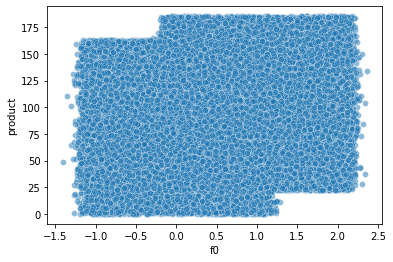

In [243]:
sns.scatterplot(data=derrick1area, x='f0', y='product', alpha=0.5)

<Axes: xlabel='product', ylabel='Count'>

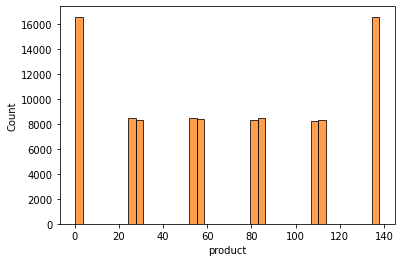

In [235]:
sns.histplot(data=derrick2area, x='product', color='tab:orange')

Таким образом:

   - для второй группы обнаружено значительное количество скважин(примерно 1/6) с нулевой производительностью;
   - параметр "f2" распределен практически дискретно и концентрируется в районе целочисленных значений(в отличии от группы 1 и 3);
   - существует соответствие между равенством нулю "product" и значениями "f2" в районе 0.
    


Было бы неплохо уточнить у заказчика - "почему так ?" или хотя бы обратить его внимание  на этот факт. Но пока лишь констатируем данную закономерность и продолжим анализ и построение модели.

Так как поставлено условием использование линейной регрессионной модели, целесообразно проверить наличие мультиколлинеарности признаков, которых три для каждой группы скважин:

In [130]:
def heatplot_tab(data, ax , name):
    corr_market = data.phik_matrix(interval_cols= ['f0', 'f1', 'f2']);
    sns.heatmap(
        corr_market,        
        cmap='RdBu_r',                
        annot=True,
        ax=ax,
        vmin=-1, vmax=1              
        );
    ax.set_title('Тепловая карта коэффициентов корреляции phik для : ' + name)

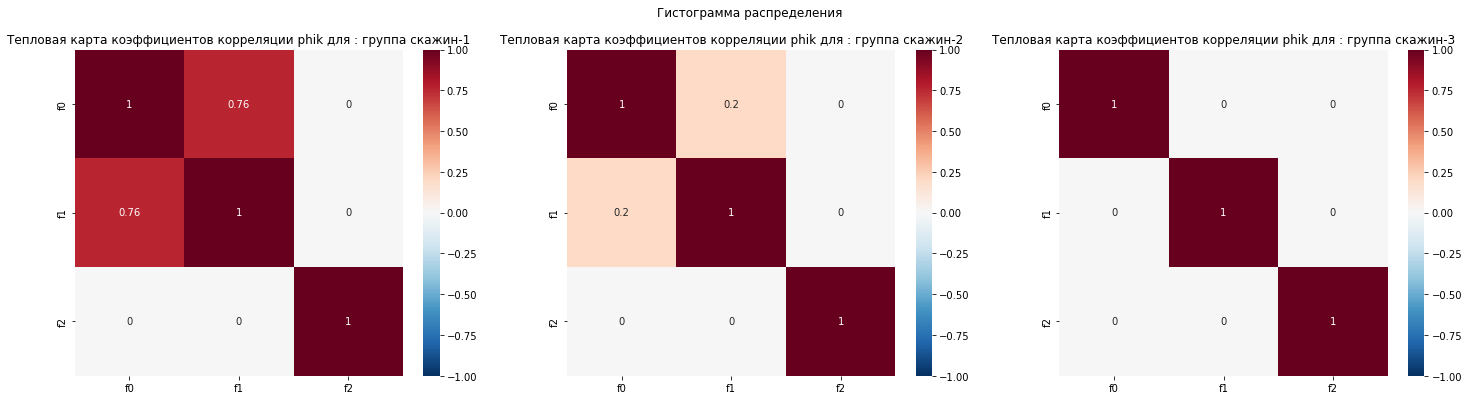

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle('Гистограмма распределения')
[heatplot_tab(item[['f0', 'f1', 'f2']], ax[i], table_names[i]) for i, item in enumerate(table_set)];
plt.show();

 - Только для первой группы скважин наблюдается сильная взаимосвязь параметра "f0" и "f1" в остальных случая все хорошо (даже идеально для группы 3 - что противоестественно 😀);
 - Считает, что мультиколлинеарность соответствует значениям более 0.9 - поэтому удалять признаки не будем.

**Выводы:** 
 - Данные загружены и обработаны, противоречий нет, не выявлено наличие Nan или иных дефектов;
 - Корреляция между параметрами находится на приемлемом уровне;
 - Отмечена особенность в данных для второй группы скважин.

## Обучение и проверка модели

Выделим признаки и целевой параметр 'product':

In [152]:
argument_col = derrick1area.columns
target = 'product'
argument_col = argument_col[~np.isin(argument_col, target)]

### Создание pipeline для модели линейной регрессии

In [145]:
def prediction_model(X_num, NumScaler, model_step):
    RANDOM_STATE = 42
    # выбор масшабирования
    if NumScaler == 'Standart':
        Scaler = StandardScaler()
    elif NumScaler == 'Robust': 
        Scaler = RobustScaler()    
    elif NumScaler == 'Quantile': 
        Scaler = QuantileTransformer()
    else:
        Scaler = MinMaxScaler()
    # обработка входных данных
    num_features = X_num.tolist()
    # преобразование численных признаков
    num_steps = [('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('Scaler', Scaler)]
    num_transformer = Pipeline(num_steps)
    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)],        
          remainder='passthrough')
    # создаём итоговый пайплайн по шагам
    step_prep = ('preprocessor', data_preprocessor)
    # выбор модели 
    if   model_step == 'LinearRegression':
        step_sol  = ('model', LinearRegression(n_jobs=-1))
    elif model_step == 'DummyRegressor':
        step_sol  = ('model', DummyRegressor(strategy="mean"))
    # собираем шаги модели
    pipe_final = Pipeline([step_prep, step_sol])
    return pipe_final

Например можно получить такую модель

In [153]:
lin_model = prediction_model(argument_col, 'Min/Max', 'LinearRegression')
lin_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression(n_jobs=-1))])

In [229]:
dummy_test_model = prediction_model(argument_col, 'Min/Max', 'DummyRegressor')

### Формирование обучающих и валидационных выборок в соотношении 75:25

In [169]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [174]:
def spliting (arguments, target):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(arguments, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return Xtrain, Xtest, Ytrain, Ytest

In [175]:
Xtrain1a, Xtest1a, Ytrain1a, Ytest1a = spliting(derrick1area[argument_col], derrick1area[target])
Xtrain2a, Xtest2a, Ytrain2a, Ytest2a = spliting(derrick2area[argument_col], derrick2area[target])
Xtrain3a, Xtest3a, Ytrain3a, Ytest3a = spliting(derrick3area[argument_col], derrick3area[target])

In [215]:
Xtrain = [Xtrain1a, Xtrain2a, Xtrain3a]
Xtest  = [Xtest1a, Xtest2a, Xtest3a]
Ytrain = [Ytrain1a, Ytrain2a, Ytrain3a]
Ytest  = [Ytest1a, Ytest2a, Ytest3a]

In [232]:
metrics = []
for i, model in enumerate(table_names):
    lin_model.fit(Xtrain[i], Ytrain[i])
    Ytest_predict = lin_model.predict(Xtest[i])
    r2_score  =  lin_model.score(Xtest[i], Ytest[i])
    rmse_score =  np.sqrt(mean_absolute_error(Ytest[i], Ytest_predict))
    
    dummy_test_model.fit(Xtrain[i], Ytrain[i])
    Ytest_predict_dummy =  dummy_test_model.predict(Xtest[i])
    rmse_score_dummy    =  np.sqrt(mean_absolute_error(Ytest[i], Ytest_predict_dummy))
    
    metrics.append([str(lin_model.get_params()['model']), r2_score, rmse_score, rmse_score_dummy])
metrics = pd.DataFrame(metrics)
metrics.columns = ['Модель', 'Метрика R2', 'Метрика RMSE', 'Метрика RMSE(Dummy)']
metrics.index  = table_names
metrics

,Модель,Метрика R2,Метрика RMSE,Метрика RMSE(Dummy)
группа скажин-1,LinearRegression(n_jobs=-1),0.272829,5.572045,6.135782
группа скажин-2,LinearRegression(n_jobs=-1),0.999625,0.846766,6.348551
группа скажин-3,LinearRegression(n_jobs=-1),0.196347,5.735587,6.150650


In [ ]:
lin_model.fit(X_train, y_train)
y_test_predict = lin_model.predict(X_test)

In [ ]:
metrics = []
for i, model in enumerate(table_names):
    lin_model.fit(X_train, y_train)
    

    
    params   = param_grid_choose(model, max_depth_tree, min_samples_split, min_samples_leaf, max_features, alpha, learning_rate, n_estimators, max_depth)
    searcher = searcher_choose('RandomizedSearchCV', test_reg_model, params, smape_scorer)
    searcher.fit(X_train, y_train)
    train_score = searcher.best_score_
    y_test_pred = searcher.predict(X_test)
    test_score  = smape(y_test, y_test_pred)
    metrics.append([-train_score, test_score, str(searcher.best_estimator_.get_params()['model'])])
    print (model+' done')
metrics = pd.DataFrame(metrics)
metrics.columns = ['SMAPE-train ', 'SMAPE-test', '1']
metrics.index  = model_list
metrics

In [ ]:
    Xtrain.append(XYi[0])
    Xtest.append(XYi[1])
    Ytrain.append(XYi[2])
    Ytest.append(XYi[3])

In [ ]:
features_train0, features_valid0, target_train0, target_valid0 = (
    train_test_split(derrick2area[argument_col], derrick2area[target], test_size=TEST_SIZE, random_state=RANDOM_STATE))

for _ in [features_train0, features_valid0, target_train0, target_valid0]:
    print(_.shape)

In [214]:
Xtrain=Xtest=Ytrain=Ytest =[]
for i, item in enumerate(table_set):
    XYi = [train_test_split(item[argument_col], item[target], test_size=TEST_SIZE, random_state=RANDOM_STATE)]
    print(XYi[0])

[             f0        f1        f2
id                                 
VZVnq  1.611925 -0.151874  1.221668
EC6JJ -0.896203  0.369086 -4.537914
PIII5  0.217569  0.974254  7.369521
80ZC3  0.882945  0.669249  3.114527
jZDSd -0.941661  0.634162  2.873607
...         ...       ...       ...
pzVvZ  1.626462 -0.107752  2.951064
0Dtx5  1.682364 -0.193385 -1.175390
cZDx4  0.979059 -0.550693  2.897510
8IHAp  0.652792 -0.484070  7.155391
zE92l  1.398239 -0.464569  2.024935

[75000 rows x 3 columns],              f0        f1        f2
id                                 
7C6bA  0.599283 -0.557623  2.121187
dVxsn  0.739017 -0.463156 -1.347584
1Gm3l  1.422743 -0.534917  3.718798
Nzg1t  1.580244 -0.238458  2.805149
Z7b4F  0.918974  0.023961  2.598575
...         ...       ...       ...
pXFCs  0.754647 -0.512213  2.610771
tf6nq -0.062056  0.516884  0.714446
pv8T0  0.593769 -0.425260 -0.525017
nol4A  0.198209  0.453940  1.497557
MUye1 -0.246727  1.013025  4.678275

[25000 rows x 3 columns], id
VZVnq 

In [213]:
Xtrain

[[             f0        f1        f2
  id                                 
  VZVnq  1.611925 -0.151874  1.221668
  EC6JJ -0.896203  0.369086 -4.537914
  PIII5  0.217569  0.974254  7.369521
  80ZC3  0.882945  0.669249  3.114527
  jZDSd -0.941661  0.634162  2.873607
  ...         ...       ...       ...
  pzVvZ  1.626462 -0.107752  2.951064
  0Dtx5  1.682364 -0.193385 -1.175390
  cZDx4  0.979059 -0.550693  2.897510
  8IHAp  0.652792 -0.484070  7.155391
  zE92l  1.398239 -0.464569  2.024935
  
  [75000 rows x 3 columns],
               f0        f1        f2
  id                                 
  7C6bA  0.599283 -0.557623  2.121187
  dVxsn  0.739017 -0.463156 -1.347584
  1Gm3l  1.422743 -0.534917  3.718798
  Nzg1t  1.580244 -0.238458  2.805149
  Z7b4F  0.918974  0.023961  2.598575
  ...         ...       ...       ...
  pXFCs  0.754647 -0.512213  2.610771
  tf6nq -0.062056  0.516884  0.714446
  pv8T0  0.593769 -0.425260 -0.525017
  nol4A  0.198209  0.453940  1.497557
  MUye1 -0.246727  

In [179]:
[XY] = [train_test_split(derrick2area[argument_col], derrick2area[target], test_size=TEST_SIZE, random_state=RANDOM_STATE)]

In [188]:
    Xtest.append(XYi[1])
    Ytrain.append(XYi[2])
    Ytest.append(XYi[3])

,f0,f1,f2
id,,,
fYVDK,6.078076,0.084568,0.002957
3SQcq,16.462386,2.712946,1.993030
hQ1gJ,7.051898,0.766983,4.990194
Y4vux,-0.240045,-0.380804,3.999693
H1NUw,13.350111,-8.558281,0.002010
...,...,...,...
Vn3pL,8.141417,-0.832158,4.001976
zZe7H,16.601751,-8.141232,2.010371
iefIy,14.674777,-5.633890,1.004171


## Подготовка к расчёту прибыли

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован

## Балуемся плюшками

Dependences are fundamental to record the computational environment.

In [41]:
!pip freeze

alembic==1.13.0
altair==5.1.2
annotated-types==0.6.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.2.1
async-lru==2.0.4
attrs==23.1.0
autopep8==2.0.4
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
blinker==1.4
catboost==1.2.2
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==3.2.0
cloudpickle==3.0.0
colorama==0.4.6
colorlog==6.8.0
comm==0.1.4
contourpy==1.1.0
cycler==0.11.0
cymem==2.0.6
dacite==1.8.1
dash-core-components==2.0.0
dash-html-components==2.0.0
dash-table==5.0.0
DAWG-Python==0.7.2
debugpy==1.6.7.post1
decorator==5.1.1
defusedxml==0.7.1
docopt==0.6.2
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
findspark==1.4.2
flatbuffers==2.0.7
fonttools==4.42.1
fqdn==1.5.1
fuzzywuzzy==0.18.0
gitdb==4.0.11
GitPython==3.1.40
graphviz==0.20.1
greenlet==3.0.2
h5py==3.9.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==6.8.0
importlib-resources==6.0.1
ipykernel==6.25.1
ipython==8.14.0
ipython-genutil